### Spoken Language Processing
В этом задании предлагается обучить классификатор класса возраста по голосу (пример с тем, как это можно сделать для пола см. в семинаре)

Подумайте, как лучше предсказывать возраст (может быть разбить на группы?) и какой лосс использовать

P.S. не забудьте, что если то вы работает в Colab, то вы можете поменять среду выполнения на GPU/TPU!

Вопросы по заданию/материалам: @Nestyme

In [1]:
%%capture

!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148

In [7]:
%%capture

!pip install torchmetrics

In [8]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'

## Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см семинар)
2. Соберите пары "голос"  — "класс возраста" также, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мелспектрограммы при помощи `torchaudio либо` `librosa`

P.S. вы можете использовать свою реализацию, а можете предложенную (см следующие ячейки)

In [3]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm
import torch as t


class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 25:
            return 0
        if 25 < age < 40:
            return 0.5
        if age > 40:
            return 1

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)


class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] if line[1] is not None else 0.0  for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

    @staticmethod
    def padd_sequences(lines, pad_token=0):
        lengths = [len(line) for line in lines]
        max_length = max(lengths)

        return np.array(
            [
                line + [pad_token] * (max_length - lengths[i])
                for i, line in enumerate(lines)
            ]
        )

Простая сверточная сеть, ее можно дотюнить или поменять по желанию

In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 1)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits).view(-1)
        return probs

    def loss(self, probs, targets):
        return nn.BCELoss()(probs.float(), targets.float())

In [5]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)

100%|██████████| 150/150 [00:14<00:00, 10.22it/s]


#Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patience = 500
best_loss = 1000
cnt = 0

In [7]:
from IPython.display import clear_output
from sklearn.metrics import *
def do_train(model, trainset, validset, testset, BATCH_SIZE = 64, **kwargs):
    global d_inp
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    patience = 500
    best_loss = 1000
    cnt = 0
    
    tqdm._instances.clear()
    

    model.to(device)
    model.train()

    history = []

    if not "optimizer" in kwargs:
        optimizer = Adam(
            [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5
        )
    else:
      optimizer = kwargs["optimizer"]

    if not "criterion" in kwargs:
      criterion = model.loss
    else:
      criterion = kwargs["criterion"]
    
    scheduler = None
    if "scheduler" in kwargs:
      scheduler = kwargs["scheduler"]

    for i in tqdm(range(5000)):

        optimizer.zero_grad()

        input, target = trainset.next_batch(BATCH_SIZE, device=device)
        out = model(input)
        loss = model.loss(out, target)
        loss.backward()
        optimizer.step()
        

        if i % 50 == 0:
            model.eval()

            with torch.no_grad():
                out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
                acc = accuracy_score(out>0.5, target>0.5)
                optimizer.zero_grad()
                input, target = validset.next_batch(BATCH_SIZE, device=device)
                out = model(input)
                valid_loss = model.loss(out, target)
                out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
                clear_output(wait=True)
                print(list(zip(target, out)))
                acc_val = accuracy_score(out>0.5, target>0.5)
                print(f'accuracy_score:{acc_val}')
                print("i {}, valid {}".format(i, valid_loss.item()))
                print("_________")
                history.append({"step": i, "loss":loss.item(), "loss_val": valid_loss.item(), "acc":acc, "acc_val": acc_val})
            
            model.train()
        if i % 50 == 0 and best_loss > valid_loss.item():
            clear_output(wait=True)
            print('new best')
            best_loss = valid_loss.item()
            torch.save(model.state_dict(), "best.pt".format(i))
            cnt = 0
        else:
            cnt += 1
        if cnt > patience:
            break
        
        if scheduler is not None:
          scheduler.step(acc_val)
    print('training finished')
    return pd.DataFrame(history)

 24%|██▍       | 1201/5000 [03:02<12:08,  5.22it/s]

[(0.5, 0.121101364), (0.5, 0.6233531), (0.5, 0.04207994), (0.5, 0.22357258), (0.5, 0.54534686), (0.0, 0.38167906), (0.5, 0.82235724), (0.5, 0.40593538), (0.5, 0.518042), (0.5, 0.45329776), (0.0, 0.2472554), (0.0, 0.02247497), (0.0, 0.49803767), (0.5, 0.82235724), (0.0, 0.13219811), (0.5, 0.07359157), (0.5, 0.21542573), (0.0, 0.7069488), (0.0, 0.014531024), (0.0, 0.036956057), (1.0, 0.7919682), (0.5, 0.43675807), (0.5, 0.1250705), (0.0, 0.92406625), (0.5, 0.28883898), (0.0, 0.02247497), (1.0, 0.22027788), (0.0, 0.18322302), (0.5, 0.31771186), (0.0, 0.8175499), (1.0, 0.5683035), (0.0, 0.526123), (0.5, 0.8529646), (0.0, 0.36882588), (1.0, 0.93639266), (0.5, 0.50672156), (0.0, 0.85900754), (0.5, 0.831815), (0.5, 0.35665926), (0.5, 0.44221312), (0.0, 0.07732117), (0.5, 0.46411687), (0.0, 0.10900521), (0.0, 0.18518105), (0.5, 0.050550558), (1.0, 0.43504405), (0.5, 0.39152983), (1.0, 0.048259817), (0.5, 0.042295426), (0.0, 0.10834663), (0.5, 0.27878374), (0.5, 0.6985069), (0.0, 0.05493182), (

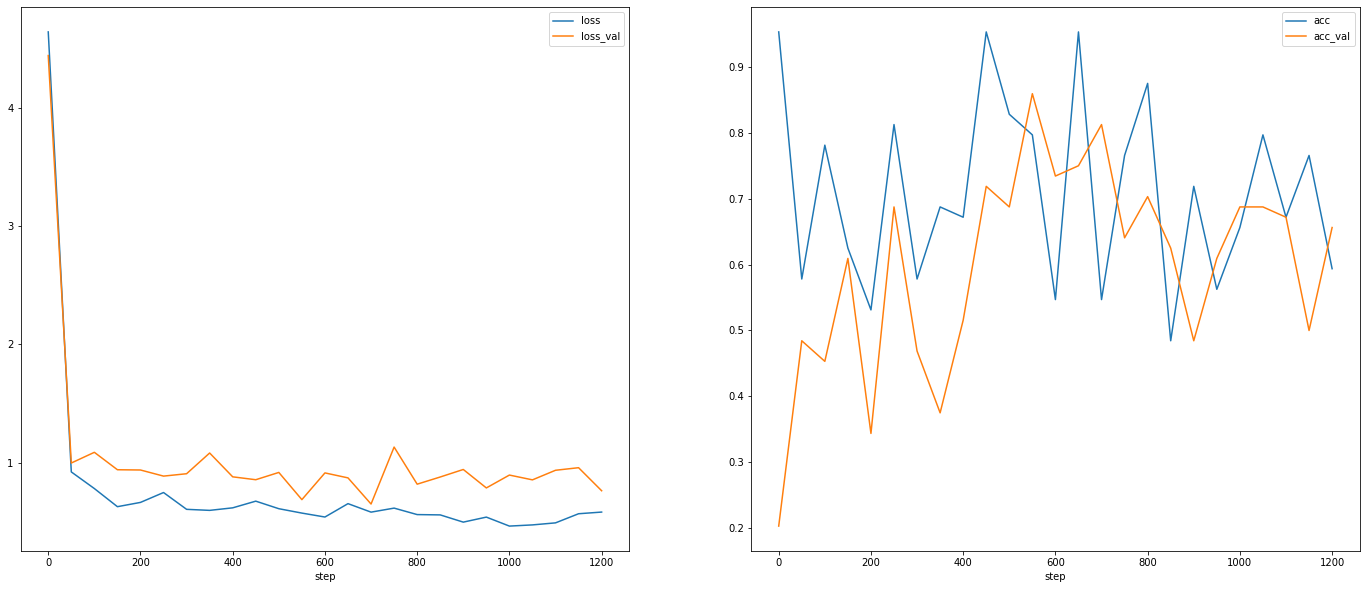

In [8]:
import pandas as pd
model = Model()
history = do_train(model, trainset, validset, testset)
_, axs = plt.subplots(1,2, figsize=(24, 10))
axs = axs.flatten()

history.plot(x="step", y="loss", ax=axs[0])
history.plot(x="step", y="loss_val", ax=axs[0])

history.plot(x="step", y="acc", ax=axs[1])
history.plot(x="step", y="acc_val", ax=axs[1])

In [9]:
history.describe()

,step,loss,loss_val,acc,acc_val
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,600.000000,0.766956,1.040279,0.709375,0.598750
std,367.990036,0.813897,0.717686,0.140697,0.154858
min,0.000000,0.462898,0.649540,0.484375,0.203125
25%,300.000000,0.557578,0.855209,0.578125,0.484375
50%,600.000000,0.595903,0.905900,0.687500,0.640625
75%,900.000000,0.652817,0.941895,0.796875,0.687500
max,1200.000000,4.643907,4.444017,0.953125,0.859375


In [9]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

In [10]:
from IPython.display import clear_output
from sklearn.metrics import *
import pandas as pd

def do_train(model, trainset, validset, testset, BATCH_SIZE = 64, **kwargs):
    global d_inp
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    patience = 500
    best_loss = 1000
    cnt = 0
    
    tqdm._instances.clear()
    

    model.to(device)
    model.train()

    history = []

    if not "optimizer" in kwargs:
        optimizer = Adam(
            [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5
        )
    else:
      optimizer = kwargs["optimizer"]

    if not "criterion" in kwargs:
      criterion = model.loss
    else:
      criterion = kwargs["criterion"]
    
    scheduler = None
    if "scheduler" in kwargs:
      scheduler = kwargs["scheduler"]

    for i in tqdm(range(5000)):

        optimizer.zero_grad()

        input, target = trainset.next_batch(BATCH_SIZE, device=device)
        out = model(input)
        loss = model.loss(out, target)
        loss.backward()
        optimizer.step()
        

        if i % 50 == 0:
            model.eval()

            with torch.no_grad():
                acc = torchmetrics.Accuracy()
                acc = acc(out.cpu(), target.long().cpu()).item()
                out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
                optimizer.zero_grad()
                input, target = validset.next_batch(BATCH_SIZE, device=device)
                out = model(input)
                valid_loss = model.loss(out, target)

                acc_val = torchmetrics.Accuracy()
                acc_val = acc_val(out.cpu(), target.long().cpu()).item()
                out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
                clear_output(wait=True)
                print(list(zip(target, out)))
                
                print(f'accuracy_score:{acc_val}')
                print("i {}, valid {}".format(i, valid_loss.item()))
                print("_________")
                history.append({"step": i, "loss":loss.item(), "loss_val": valid_loss.item(), "acc":acc, "acc_val": acc_val})
            
            model.train()
        if i % 50 == 0 and best_loss > valid_loss.item():
            clear_output(wait=True)
            print('new best')
            best_loss = valid_loss.item()
            torch.save(model.state_dict(), "best.pt".format(i))
            cnt = 0
        else:
            cnt += 1
        if cnt > patience:
            break
        
        if scheduler is not None:
          scheduler.step(acc_val)
    print('training finished')
    return pd.DataFrame(history)

 12%|█▏        | 601/5000 [01:27<14:04,  5.21it/s]

[(0.5, 0.16397117), (0.5, 0.6411338), (1.0, 0.8071781), (0.5, 0.69991547), (0.5, 0.075467765), (1.0, 0.7787882), (0.0, 0.51491535), (0.5, 0.8614537), (1.0, 0.0878297), (0.5, 0.78440535), (0.0, 0.56242394), (1.0, 0.27182612), (0.0, 0.49690852), (0.0, 0.7164875), (0.5, 0.10232744), (0.0, 0.32929626), (0.5, 0.6002282), (0.5, 0.26092947), (0.5, 0.50440884), (0.5, 0.2558718), (0.5, 0.44235548), (0.5, 0.1633538), (0.0, 0.2892667), (0.5, 0.7266297), (0.0, 0.28536522), (0.5, 0.81399316), (0.0, 0.873385), (1.0, 0.5256669), (0.5, 0.08898778), (0.0, 0.1415334), (0.5, 0.46327522), (1.0, 0.7468683), (0.5, 0.14447625), (0.5, 0.4548299), (0.0, 0.8487911), (1.0, 0.27182612), (0.5, 0.56880844), (0.0, 0.9813669), (1.0, 0.5256669), (0.5, 0.4040989), (0.0, 0.25705394), (0.0, 0.7755619), (0.5, 0.31207606), (0.5, 0.23361021), (0.5, 0.9160521), (0.5, 0.2964125), (0.0, 0.109391846), (0.0, 0.16462505), (0.0, 0.32929626), (0.0, 0.421117), (0.5, 0.97699183), (0.0, 0.30200246), (0.5, 0.121738054), (0.5, 0.1113312

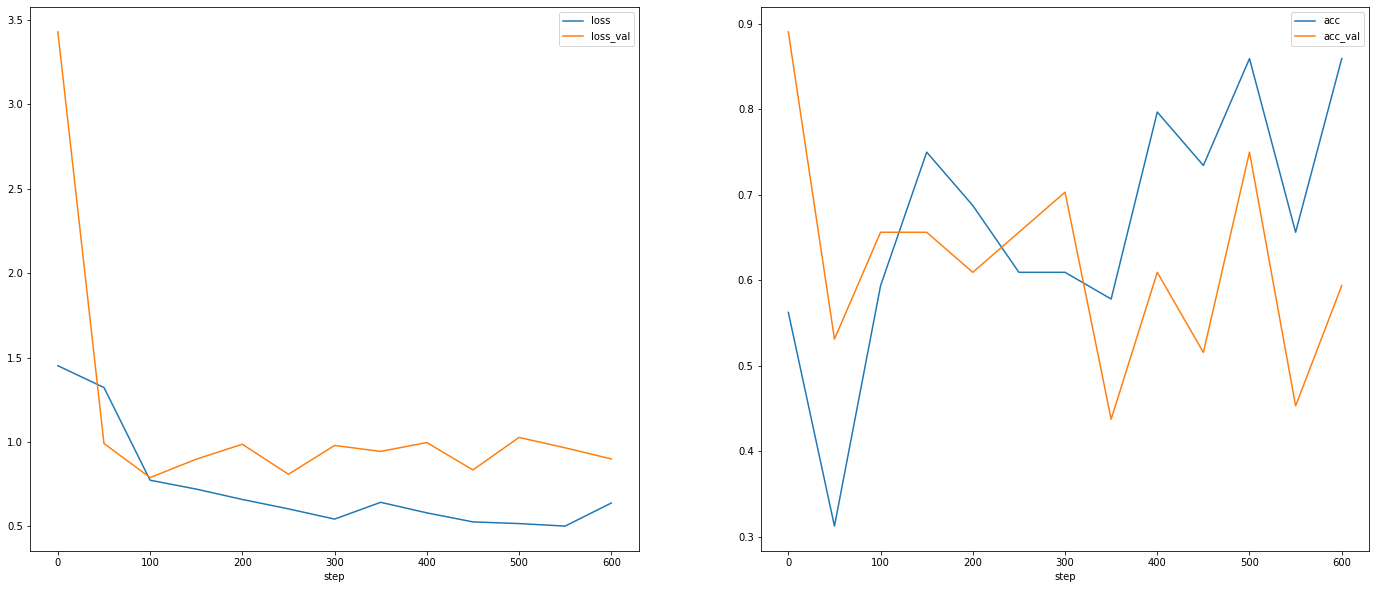

In [16]:
model = Model()
history = do_train(model, trainset, validset, testset, criterion=nn.CrossEntropyLoss())
_, axs = plt.subplots(1,2, figsize=(24, 10))
axs = axs.flatten()

history.plot(x="step", y="loss", ax=axs[0])
history.plot(x="step", y="loss_val", ax=axs[0])

history.plot(x="step", y="acc", ax=axs[1])
history.plot(x="step", y="acc_val", ax=axs[1])

In [17]:
history.describe()

,step,loss,loss_val,acc,acc_val
count,13.000000,13.000000,13.000000,13.000000,13.000000
mean,300.000000,0.728760,1.118801,0.662260,0.620192
std,194.722024,0.303939,0.698669,0.146927,0.123095
min,0.000000,0.501033,0.788685,0.312500,0.437500
25%,150.000000,0.542491,0.897539,0.593750,0.531250
50%,300.000000,0.637727,0.965022,0.656250,0.609375
75%,450.000000,0.720335,0.990529,0.750000,0.656250
max,600.000000,1.451626,3.430123,0.859375,0.890625


 31%|███       | 1551/5000 [03:41<10:06,  5.69it/s]

[(0.5, 0.29956815), (0.5, 0.40706617), (0.5, 0.7333734), (0.5, 0.36002567), (0.5, 0.35362086), (1.0, 0.19342169), (0.5, 0.85401255), (0.0, 0.47293505), (0.5, 0.42149726), (0.5, 0.62594026), (0.0, 0.81386554), (1.0, 0.7944106), (0.5, 0.0004484517), (0.0, 0.89413136), (0.5, 0.1887922), (0.5, 0.48651928), (0.0, 0.56438655), (1.0, 0.9135752), (0.5, 0.22427082), (0.5, 0.21219285), (0.0, 0.22186983), (0.0, 0.40164793), (0.5, 0.5589261), (0.0, 0.25611553), (1.0, 0.8318746), (0.0, 0.4140559), (0.0, 0.218668), (1.0, 0.90562177), (0.5, 0.26458493), (0.0, 0.77755076), (0.5, 0.7213349), (0.5, 0.9296505), (0.5, 0.38950685), (0.5, 0.8041686), (1.0, 0.9249476), (0.0, 0.5101001), (0.0, 0.97035766), (0.5, 0.11201543), (0.0, 0.03738235), (0.5, 0.10793443), (1.0, 0.8526515), (0.5, 0.25585935), (0.5, 0.6964001), (0.5, 0.07665949), (0.0, 0.14755793), (0.0, 0.32259995), (0.5, 0.2519669), (1.0, 0.7197857), (0.0, 0.43820962), (0.5, 0.7876716), (0.0, 0.6597446), (0.0, 0.16997397), (0.0, 0.7712374), (0.5, 0.121

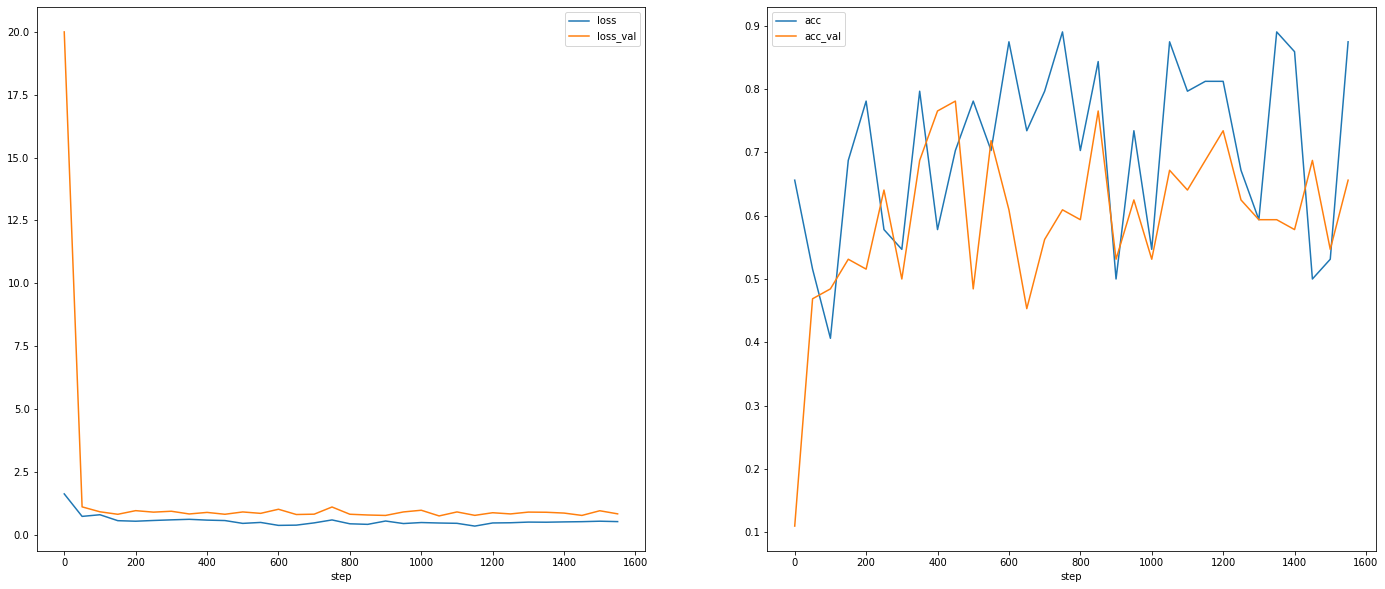

In [11]:
model = Model()
history = do_train(model, trainset, validset, testset, criterion=LabelSmoothingCrossEntropy())
_, axs = plt.subplots(1,2, figsize=(24, 10))
axs = axs.flatten()

history.plot(x="step", y="loss", ax=axs[0])
history.plot(x="step", y="loss_val", ax=axs[0])

history.plot(x="step", y="acc", ax=axs[1])
history.plot(x="step", y="acc_val", ax=axs[1])

In [12]:
history.describe()

,step,loss,loss_val,acc,acc_val
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,775.000000,0.566627,1.493022,0.705566,0.593262
std,469.041576,0.216780,3.376110,0.138913,0.126595
min,0.000000,0.362532,0.766062,0.406250,0.109375
25%,387.500000,0.481722,0.832757,0.578125,0.531250
50%,775.000000,0.524962,0.899410,0.718750,0.601562
75%,1162.500000,0.583250,0.935685,0.812500,0.675781
max,1550.000000,1.641036,19.988029,0.890625,0.781250


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp


##
# version 1: use torch.autograd
class FocalLossV1(nn.Module):

    def __init__(self,
                 alpha=0.25,
                 gamma=2,
                 reduction='mean',):
        super(FocalLossV1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, label):
        '''
        logits and label have same shape, and label data type is long
        args:
            logits: tensor of shape (N, ...)
            label: tensor of shape(N, ...)
        '''

        # compute loss
        logits = logits.float() # use fp32 if logits is fp16
        with torch.no_grad():
            alpha = torch.empty_like(logits).fill_(1 - self.alpha)
            alpha[label == 1] = self.alpha

        probs = torch.sigmoid(logits)
        pt = torch.where(label == 1, probs, 1 - probs)
        ce_loss = self.crit(logits, label.float())
        loss = (alpha * torch.pow(1 - pt, self.gamma) * ce_loss)
        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss


 38%|███▊      | 1901/5000 [04:35<09:25,  5.48it/s]

[(0.5, 0.35708037), (0.5, 0.06193486), (0.5, 0.3939043), (0.5, 0.014326812), (0.5, 0.06193486), (1.0, 0.5753736), (0.5, 0.19294575), (0.5, 0.6137154), (1.0, 0.35864997), (0.0, 0.35705167), (0.5, 0.5944889), (0.5, 0.55348235), (0.5, 0.25572893), (0.0, 0.09235816), (0.5, 0.25658503), (0.0, 0.9069298), (0.5, 0.48897353), (0.5, 0.8600701), (1.0, 0.47523373), (1.0, 0.858288), (0.5, 0.35216713), (0.0, 0.16242471), (0.0, 0.18226065), (0.0, 0.23527934), (0.5, 0.3939043), (1.0, 0.032414522), (1.0, 0.9418519), (0.5, 0.30657947), (0.5, 0.010500431), (0.5, 0.30870265), (0.5, 0.76521903), (1.0, 0.1035036), (0.5, 0.5421553), (0.5, 0.2165158), (0.5, 0.120386995), (0.5, 0.6071625), (1.0, 0.34547403), (0.5, 0.3521488), (0.5, 0.76521903), (1.0, 0.858288), (0.5, 0.73683214), (0.5, 0.3719355), (0.5, 0.18190645), (0.0, 0.38122904), (0.5, 0.10345653), (0.5, 0.7807417), (0.5, 0.07842392), (0.0, 0.094093144), (0.0, 0.0169085), (0.5, 0.21106513), (0.5, 0.3760427), (0.5, 0.6065253), (0.5, 0.12953442), (1.0, 0.3

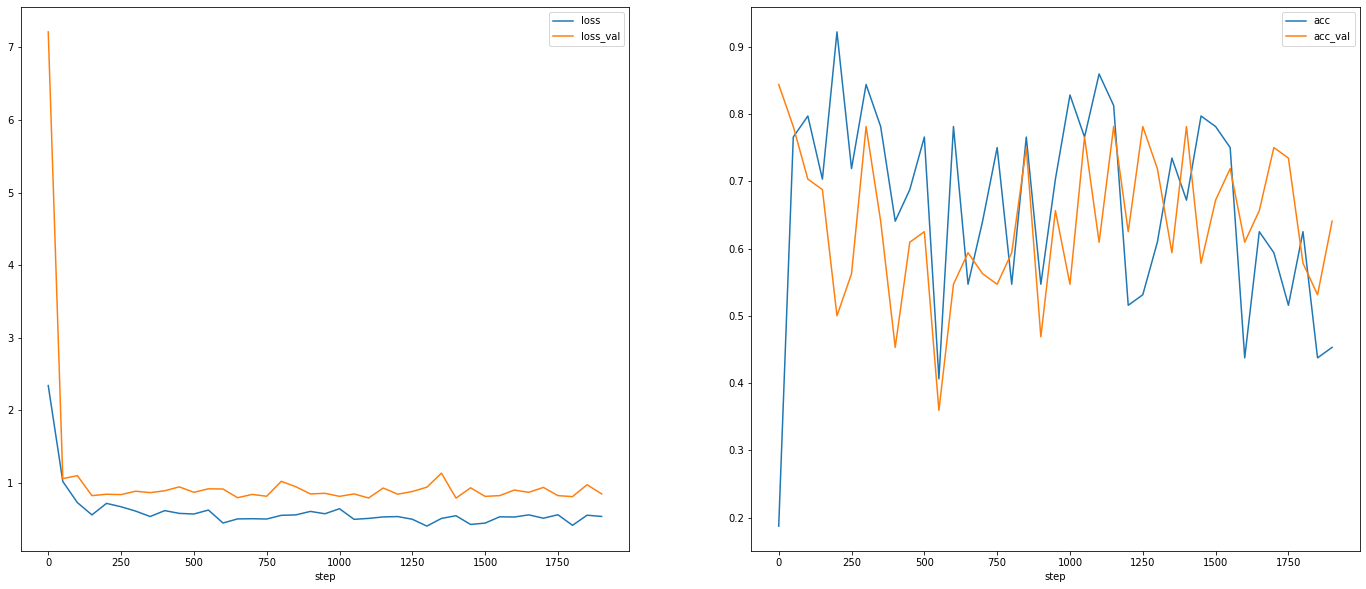

In [22]:
model = Model()
history = do_train(model, trainset, validset, testset, criterion=FocalLossV1())
_, axs = plt.subplots(1,2, figsize=(24, 10))
axs = axs.flatten()

history.plot(x="step", y="loss", ax=axs[0])
history.plot(x="step", y="loss_val", ax=axs[0])

history.plot(x="step", y="acc", ax=axs[1])
history.plot(x="step", y="acc_val", ax=axs[1])

In [23]:
history.describe()

,step,loss,loss_val,acc,acc_val
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,950.000000,0.603766,1.050395,0.662660,0.639423
std,570.087713,0.303779,1.016097,0.152661,0.107621
min,0.000000,0.403619,0.789035,0.187500,0.359375
25%,475.000000,0.507177,0.830445,0.546875,0.570312
50%,950.000000,0.546258,0.868781,0.703125,0.625000
75%,1425.000000,0.592319,0.933772,0.773438,0.726562
max,1900.000000,2.339767,7.213120,0.921875,0.843750


In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
model = Model()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=32)

history = do_train(model, trainset, validset, testset, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

 10%|█         | 501/5000 [01:17<14:36,  5.13it/s]

[(0.0, 0.0), (1.0, 0.0), (0.5, 0.0), (0.0, 0.0), (1.0, 0.0), (0.5, 0.0), (0.0, 0.0), (1.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (1.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (1.0, 0.0), (0.0, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.0, 0.0), (1.0, 0.0), (0.5, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5, 0.0), (0.0, 0.0), (0.0, 0.0), (1.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (1.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0)]
accuracy_score:0.84375
i 500, valid 35.9375
_________
training finished


In [12]:
history.describe()

,step,loss,loss_val,acc,acc_val
count,11.00000,11.000000,11.000000,11.000000,11.000000
mean,250.00000,39.404978,40.482955,0.806818,0.867898
std,165.83124,12.783985,3.934557,0.187145,0.031533
min,0.00000,2.204756,35.156250,0.250000,0.812500
25%,125.00000,39.453125,37.500000,0.835938,0.843750
50%,250.00000,42.187500,40.625000,0.859375,0.875000
75%,375.00000,45.312500,42.578125,0.882812,0.882812
max,500.00000,49.218750,46.875000,0.906250,0.921875


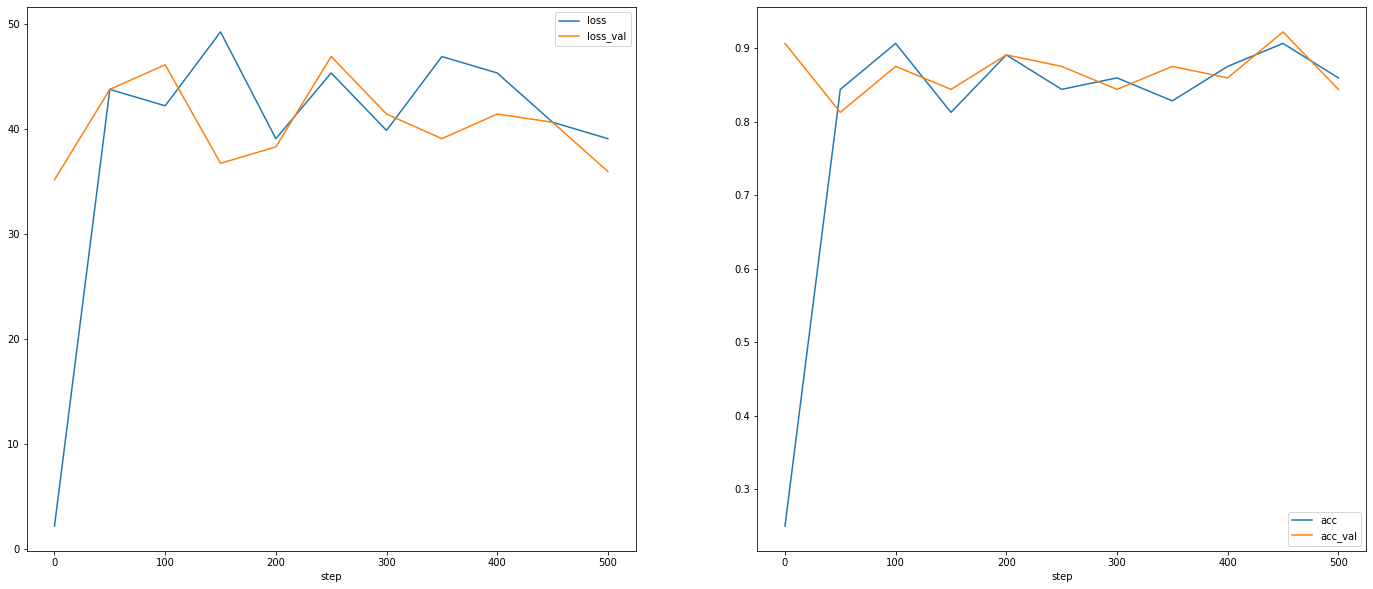

In [13]:
_, axs = plt.subplots(1,2, figsize=(24, 10))
axs = axs.flatten()

history.plot(x="step", y="loss", ax=axs[0])
history.plot(x="step", y="loss_val", ax=axs[0])

history.plot(x="step", y="acc", ax=axs[1])
history.plot(x="step", y="acc_val", ax=axs[1])

In [30]:
class AdvancedModel(Model):
    def __init__(self, window_sizes=(3, 4, 5, 6)):
        super(AdvancedModel, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc1 = nn.Linear(128 * len(window_sizes), 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Apply a convolution + max pool layer for each window size
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits1 = self.fc1(x)  # [B, class]
        logits=self.fc2(logits1)
        probs = torch.sigmoid(logits).view(-1)
        return probs
    

 10%|█         | 501/5000 [01:19<15:13,  4.93it/s]

[(0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (1.0, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (1.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.0, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (1.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0), (0.0, 0.0), (0.5, 0.0), (0.5, 0.0), (0.5, 0.0)]
accuracy_score:0.875
i 500, valid 47.65625
_________
training finished


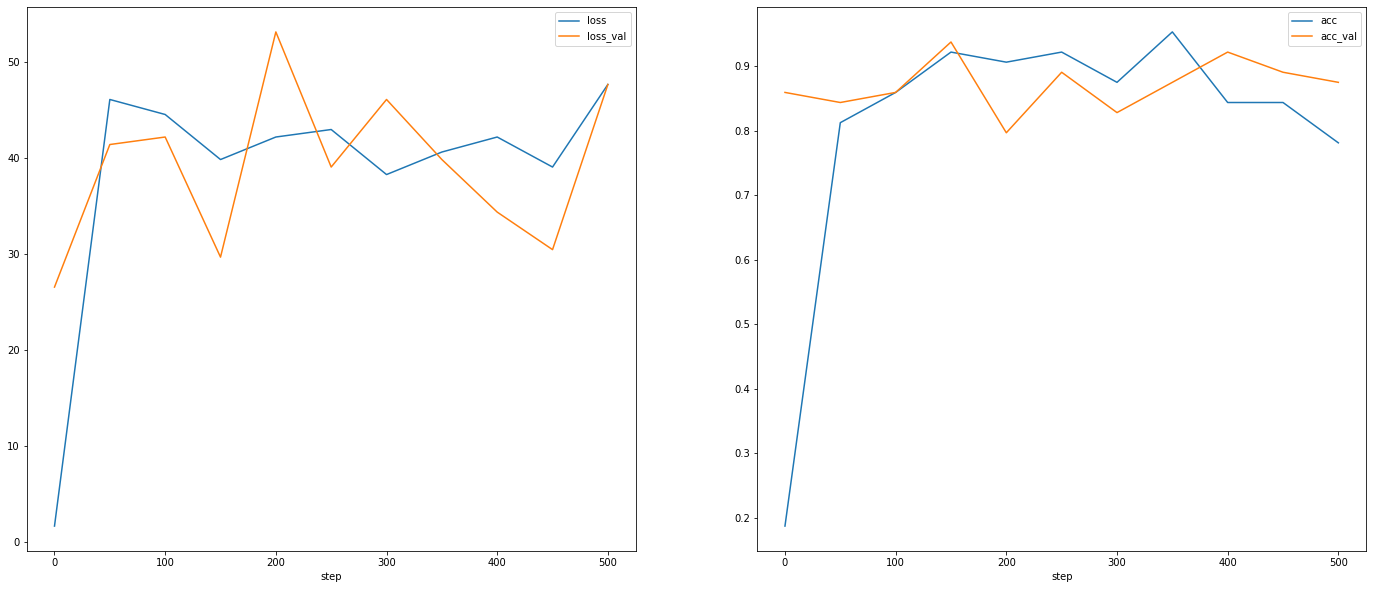

In [31]:
model = AdvancedModel()
history = do_train(model, trainset, validset, testset)
_, axs = plt.subplots(1,2, figsize=(24, 10))
axs = axs.flatten()

history.plot(x="step", y="loss", ax=axs[0])
history.plot(x="step", y="loss_val", ax=axs[0])

history.plot(x="step", y="acc", ax=axs[1])
history.plot(x="step", y="acc_val", ax=axs[1])

In [86]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm
import torch as t


class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 30:
            return 0
        if 30 < age < 45:
            return 1
        if age > 45:
            return 2

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)


class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] if line[1] is not None else 0.0  for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

    @staticmethod
    def padd_sequences(lines, pad_token=0):
        lengths = [len(line) for line in lines]
        max_length = max(lengths)

        return np.array(
            [
                line + [pad_token] * (max_length - lengths[i])
                for i, line in enumerate(lines)
            ]
        )

In [87]:
try:
  tqdm._instances.clear()
except:
  pass

  
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)

100%|██████████| 150/150 [00:21<00:00,  7.02it/s]


In [91]:
def do_train(model, trainset, validset, testset, BATCH_SIZE = 64, **kwargs):
    global d_inp
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    patience = 500
    best_loss = 1000
    cnt = 0
    
    tqdm._instances.clear()
    

    model.to(device)
    model.train()

    history = []

    if not "optimizer" in kwargs:
        optimizer = Adam(
            [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5
        )
    else:
      optimizer = kwargs["optimizer"]

    if not "criterion" in kwargs:
      criterion = model.loss
    else:
      criterion = kwargs["criterion"]
    
    scheduler = None
    if "scheduler" in kwargs:
      scheduler = kwargs["scheduler"]

    for i in tqdm(range(5000)):

        optimizer.zero_grad()

        input, target = trainset.next_batch(BATCH_SIZE, device=device)
        out = model(input)
        loss = model.loss(out, target)
        loss.backward()
        optimizer.step()
        

        if i % 50 == 0:
            model.eval()

            with torch.no_grad():
                acc = torchmetrics.Accuracy()
                acc = acc(out.cpu(), target.long().cpu()).item()
                out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
                optimizer.zero_grad()
                input, target = validset.next_batch(BATCH_SIZE, device=device)
                out = model(input)
                valid_loss = model.loss(out, target)

                acc_val = torchmetrics.Accuracy()
                acc_val = acc_val(out.cpu(), target.long().cpu()).item()
                out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
                clear_output(wait=True)
                print(list(zip(target, out)))
                
                print(f'accuracy_score:{acc_val}')
                print("i {}, valid {}".format(i, valid_loss.item()))
                print("_________")
                history.append({"step": i, "loss":loss.item(), "loss_val": valid_loss.item(), "acc":acc, "acc_val": acc_val})
            
            model.train()
        if i % 50 == 0 and best_loss > valid_loss.item():
            clear_output(wait=True)
            print('new best')
            best_loss = valid_loss.item()
            torch.save(model.state_dict(), "best.pt".format(i))
            cnt = 0
        else:
            cnt += 1
        if cnt > patience:
            break
        
        if scheduler is not None:
          scheduler.step(acc_val)
    print('training finished')
    return pd.DataFrame(history)

 24%|██▍       | 1201/5000 [03:06<12:29,  5.07it/s]

[(1.0, array([1.0000000e+00, 1.5277421e-28, 0.0000000e+00], dtype=float32)), (0.0, array([1., 0., 0.], dtype=float32)), (1.0, array([1., 0., 0.], dtype=float32)), (0.0, array([1., 0., 0.], dtype=float32)), (0.0, array([1.e+00, 7.e-45, 0.e+00], dtype=float32)), (0.0, array([1., 0., 0.], dtype=float32)), (0.0, array([1.0e+00, 1.3e-44, 0.0e+00], dtype=float32)), (1.0, array([1., 0., 0.], dtype=float32)), (0.0, array([1.0000000e+00, 4.9711976e-37, 0.0000000e+00], dtype=float32)), (1.0, array([1.000000e+00, 1.014833e-39, 0.000000e+00], dtype=float32)), (1.0, array([1.00e+00, 5.24e-43, 0.00e+00], dtype=float32)), (0.0, array([1.0000000e+00, 4.2357396e-37, 0.0000000e+00], dtype=float32)), (0.0, array([1.000000e+00, 6.827068e-36, 0.000000e+00], dtype=float32)), (0.0, array([1.00000e+00, 2.27117e-34, 0.00000e+00], dtype=float32)), (0.0, array([1., 0., 0.], dtype=float32)), (0.0, array([1.0000000e+00, 1.1951476e-35, 0.0000000e+00], dtype=float32)), (1.0, array([1.e+00, 1.e-45, 0.e+00], dtype=flo

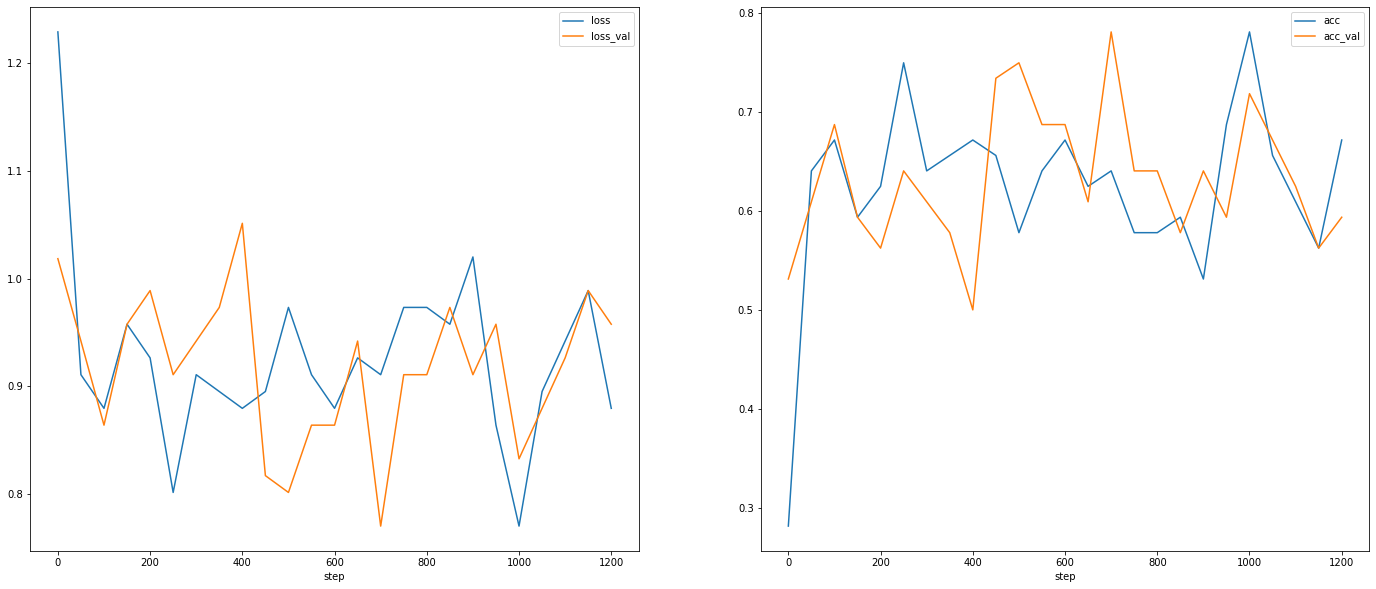

In [92]:
model = AdvancedModel()
history = do_train(model, trainset, validset, testset)
_, axs = plt.subplots(1,2, figsize=(24, 10))
axs = axs.flatten()

history.plot(x="step", y="loss", ax=axs[0])
history.plot(x="step", y="loss_val", ax=axs[0])

history.plot(x="step", y="acc", ax=axs[1])
history.plot(x="step", y="acc_val", ax=axs[1])

In [93]:
history.describe()

,step,loss,loss_val,acc,acc_val
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,600.000000,0.926056,0.918256,0.623750,0.633125
std,367.990036,0.084111,0.068918,0.090427,0.069016
min,0.000000,0.770195,0.770195,0.281250,0.500000
25%,300.000000,0.879570,0.863945,0.593750,0.593750
50%,600.000000,0.910820,0.926445,0.640625,0.625000
75%,900.000000,0.957695,0.957695,0.671875,0.687500
max,1200.000000,1.229218,1.051445,0.781250,0.781250


### Заключение

сначала была проверена простая модель на обычной бинарной классификации, до 40 лет и после, которая показала высокое качество точности (~94%), затем уже была проверена модель на всех категориях возрастов на CE и на LabelSmoothing и на FocalLoss, давшие примерно одинаковые результаты ~93-95%
попытка сменить оптимизатор и добавить шедулер - SGD и ReduceLROnPlateau, не увенчались успехом, качество не было выше 90%

Также была добавлена модель с доп линейным слоем и увеличением слоя CNN (доп. window size), но подобная модель также получила качество около 90% при дефолтном оптимизаторе и CE

Была попытка сместить возврасты в большую сторону, но качество просело до 67% , а следовательно, нужно смещать возрасты в меньшую сторону

Вывод такой, что вследствие недостатка данных и дисбаланса по возрастам, мы наблюдаем довольно нестабильный процесс тренировки, что можно сделать - разбить иначе на категории, сместив возрасты, и добавить данные, либо использовать transfer learning и недавно вышедшую модель wav2vec2 , использовав ее как feature extractor и подав feature либо на линейный слов классификации, либо предварительно обработав LSTM слоем. но я не стал это проверять ввиду затратности по времени (нужно еще переделать обработку данных), хотя небольшой опыт тюнинга wav2vec2, у меня есть (моя моделька https://huggingface.co/imvladikon/wav2vec2-large-xlsr-53-hebrew ;) )